<a href="https://colab.research.google.com/github/tinanemati/Skamina_Hiker_GPS_Improved/blob/main/Skamania_Hiker's_GPS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [ ]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Helper Classes

## 1.1 Perlin Noise

In [ ]:
# Perline noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v)

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

if __name__ == 'main':
    lin = np.linspace(0,5,100,endpoint=False)
    x,y = np.meshgrid(lin,lin)

    plt.imshow(perlin(x,y,seed=5),origin='upper')
    plt.show()

## 1.2 Point

In [ ]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.comparator = math.inf

	def __lt__(self, other):
		return self.comparator < other.comparator

	def __gt__(self, other):
		return self.comparator > other.comparator

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map 

In [ ]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, seed=None, filename=None, start=None,
              goal=None):

		self.seed = seed
		if self.seed == None:
		# Randomly assign seed from 0 to 10k if not provided
			self.seed = randint(0,10000)
		self.length = length
		self.width = width
		self.generateTerrain(filename)
		self.explored = []
		self.explored_lookup = {}
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5))
		else:
			self.start = Point(start[0], start[1])
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9))
		else:
			self.goal = Point(goal[0], goal[1])
		self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
    
	'''generateTerrain: modifes self.map to either be the specified file, or
	randomly generated from perlin noise.
	input:
	filename - str, string of the npy file to generate the map
	seed - int, integer for reproducibility of a particular map
	octaves - int parameter for perlin noise
	output:
	None, self.map modified'''
	def generateTerrain(self, filename=None):
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (0.0 > w):
			return a0
		if (1.0 < w):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculatePathCost(self, path):
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.isAdjacent(prev, item):
				cost += self.getCost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def validTile(self, x, y):
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	'''def validTile(self, p1):
		return self.validTile(p1.x, p1.y)'''

	def getTile(self, x, y):
		try:
			return self.map[x][y]
		except:
			print(x)
			print(y)
			print(self.length)
			print(self.width)
			raise()

	'''def getTile(self, p1):
		return self.getTile(p1.x, p1.y)'''

	def getCost(self, p1, p2):
		h0 = self.getTile(p1.x, p1.y)
		h1 = self.getTile(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def isAdjacent(self, p1, p2):
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def getNeighbors(self, p1):
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.validTile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
		return neighbors

	def getStartPoint(self):
		return self.start

	def getEndPoint(self):
		return self.goal

	def getHeight(self):
		return np.amax(self.map)

	'''Creates a 2D image of the path taken and nodes explroed, prints
	pathcost and number of nodes explored'''
	def createImage(self, path):
		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculatePathCost(path))
		cmap = mpl.colors.ListedColormap(['white', 'red'])
		print('Nodes explored: ', len(self.explored) + len(path))
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, linewidth=1)
		plt.show()

	'''Set the start and goal point on the 2D map, each point is a pair of integers'''
	def setStartGoal(self, start, goal):
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

# 2. AI Modules

You'll write your code here!

## 2.1 AI Module & Dijkstras

In [ ]:
'''AIModule Interface
createPath(map map_) -> list<points>: Adds points to a path'''
class AIModule:

	def createPath(self, map_):
		pass

'''
A sample AI that takes a very suboptimal path.
This is a sample AI that moves as far horizontally as necessary to reach
the target, then as far vertically as necessary to reach the target.
It is intended primarily as a demonstration of the various pieces of the
program.
'''
class StupidAI(AIModule):

	def createPath(self, map_):
		path = []
		explored = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def createPath(self, map_):
		q = PriorityQueue()
		''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		node), previous (node -> parent). This keeps track of paths, and explored
		which helps us run faster by ignoring nodes already visited'''
		cost = {}
		prev = {}
		explored = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost[str(i)+','+str(j)] = math.inf
				prev[str(i)+','+str(j)] = None
				explored[str(i)+','+str(j)] = False
		current_point = deepcopy(map_.start)
		current_point.comparator = 0
		cost[str(current_point.x)+','+str(current_point.y)] = 0
		# Add start node to the queue
		q.put(current_point)
		# Search loop
		while q.qsize() > 0:
			# Get new point from PQ
			v = q.get()
			if explored[str(v.x)+','+str(v.y)]:
				continue
			explored[str(v.x)+','+str(v.y)] = True
			# Check if popping off goal
			if v.x == map_.getEndPoint().x and v.y == map_.getEndPoint().y:
				break
			# Evaluate neighbors
			neighbors = map_.getNeighbors(v)
			for neighbor in neighbors:
				alt = map_.getCost(v, neighbor) + cost[str(v.x)+','+str(v.y)]
				if alt < cost[str(neighbor.x)+','+str(neighbor.y)]:
					cost[str(neighbor.x)+','+str(neighbor.y)] = alt
					neighbor.comparator = alt
					prev[str(neighbor.x)+','+str(neighbor.y)] = v
				q.put(neighbor)
		# Find and return path
		path = []
		while not(v.x == map_.getStartPoint().x and v.y == map_.getStartPoint().y):
			path.append(v)
			v = prev[str(v.x)+','+str(v.y)]
		path.append(map_.getStartPoint())
		path.reverse()
		return path

## 2.2 AIExp and AIMSH
Here, specifically

This part of the progarm is divided into two parts. 

***Part 1***: This part is designed to find the optimal path and admissible heauristic to ensure the optimal path.

In the first step, we created a class that inheretide from the AIModule 

```
AstarExp(AIModule)
```

In the class, we defined an admissible heaurstic in as a mathematical equation. In designing our heuristics, we divided it in 3 cases. The cases are as followed: 

    case 1: moving in a flat plane, heurostic: chebyshev distance
    case 2: moving downward, heuristic: e^(slope) * d
    case 3: moving upward, heuristic: e * delta_H

In creating a path for our implemented A* algorithm, we took help from the 
```
Dijkstras(AIModule)
```
and created our path using the similar algorithm. 

***Part 2***: This part of the program is designed to find the optimal route for the MSH problem. In order to be able to meet the requirments we had to modify our ***A**** approach and use an ***A**** variant. 

The variant of our choosing for this problem was ***Bidirectional Search***. This variant allows us to search from the start to the goal and from the goal to the start, when both sides exoand the same node we are finished. Additionaly, we can use the same heurstic as the ***A**** method since it has already been proven to be admissible. 

We used ***bidirectional search*** because we believed that it would help in this situation. Even though we are aware that the ***bidirectional search*** does not provide the optimal path cost all the time, but in a case that our a big tree like the MSH problem, it is much easier to have two small search trees that fans out over the map instead of a big tree. 

It is important to mention that in creating a path for our ***A-star varriant*** approach, even though we seeked help from the 

    AStarExp(AIModule) 
    
we had to take couple important changes in our implementation as explained bellow: 

1. Two queues were created: q1 is for forward search and q2 is for backward search. This will allow us to search both queues in parallel until they meet and the popping off goal where v1 and v2 are the same.
2. Switching the order of neighbor and v2 to get the cost when evaluating backwards because even though we are going from goal to start, our path cost should be calculated from start to goal that is why we impleted it like the following in the code: 
```
  neighbors2 = map_.getNeighbors(v2)	 		
	for neighbor in neighbors2:
		alt = cost2[str(v2.x)+','+str(v2.y)] + map_.getCost(neighbor, v2)
```
3. Popping the repeated node when creating the final path. When appending the forward and backward path, we need to make sure we do not have any repeated nodes by creating a dummy value(count). We beileved this was the fastest way to achieve the following without slowing down the program. 
```
path1 = [] 
# Create the path for forward
while not(v1.x == map_.getStartPoint().x and v1.y == map_.getStartPoint().y):
	path1.append(v1)
	v1 = prev1[str(v1.x)+','+str(v1.y)]
path1.append(map_.getStartPoint())
path1.reverse()
# Create the path for backward
path2 = []
count = 0
while not(v2.x == map_.getEndPoint().x and v2.y == map_.getEndPoint().y):
	if count != 0:
		path2.append(v2)
	v2 = prev2[str(v2.x)+','+str(v2.y)]
	count += 1
path2.append(map_.getEndPoint())
final_path = path1 + path2 
```


In [ ]:
class AStarExp(AIModule):
	
	def get_heuristic (self, map_, neighbor, endpoint):
			heuristic = 0
			delta_H = math.log(map_.getCost(neighbor, endpoint))
	 
			# case 1 : move in a flat plane, heuristic: chebyshev distance
			if (delta_H == 0):
				heuristic = max(abs(neighbor.x - endpoint.x), abs(neighbor.y - endpoint.y))
		
			# case 2: move downward, heuristic: e^(slope) * d
			elif (delta_H < 0):
				d = max(abs(neighbor.x - endpoint.x), abs(neighbor.y - endpoint.y))
				slope = delta_H / d
				heuristic = math.pow(math.e,slope) * d
		
			# case 3: move upward, heuristic: e * delta_h
			elif (delta_H > 0):
				heuristic = delta_H * math.e
			return heuristic

	def createPath(self, map_):
		q = PriorityQueue()
		# ''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		# node), previous (node -> parent). This keeps track of paths, and explored
		# which helps us run faster by ignoring nodes already visited'''
		cost = {}
		prev = {}
		explored = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost[str(i)+','+str(j)] = math.inf
				prev[str(i)+','+str(j)] = None
				explored[str(i)+','+str(j)] = False
		current_point = deepcopy(map_.start)
		current_point.comparator = 0
		cost[str(current_point.x)+','+str(current_point.y)] = 0
		# Add start node to the queue
		q.put(current_point)
		# Search loop
		while q.qsize() > 0:
			# Get new point from PQ
			v = q.get()
			if explored[str(v.x)+','+str(v.y)]:
				continue
			explored[str(v.x)+','+str(v.y)] = True
			# Check if popping off goal
			if v.x == map_.getEndPoint().x and v.y == map_.getEndPoint().y:
				break
			# Evaluate neighbors
			neighbors = map_.getNeighbors(v)
			for neighbor in neighbors:
				alt = cost[str(v.x)+','+str(v.y)] + map_.getCost(v, neighbor)
				if alt < cost[str(neighbor.x)+','+str(neighbor.y)]:
					cost[str(neighbor.x)+','+str(neighbor.y)] = alt

					# f(n) = g(n) + h(n) add heuristic 
					neighbor.comparator = alt + self.get_heuristic(map_,neighbor, map_.getEndPoint())
					prev[str(neighbor.x)+','+str(neighbor.y)] = v
				q.put(neighbor)
		# Find and return path
		path = []
		while not(v.x == map_.getStartPoint().x and v.y == map_.getStartPoint().y):
			path.append(v)
			v = prev[str(v.x)+','+str(v.y)]
		path.append(map_.getStartPoint())
		path.reverse()
	
		return path
		

class AStarMSH(AIModule):
	#Variant choice: Bidirectional Search

	#Use the same Heuristic as the A star
	def get_heuristic (self, map_, neighbor, endpoint):
				heuristic = 0
				delta_H = math.log(map_.getCost(neighbor, endpoint))
		
				# case 1 : move in a flat plane, heuristic: chebyshev
				if (delta_H == 0):
					heuristic = max(abs(neighbor.x - endpoint.x), abs(neighbor.y - endpoint.y))
			
				# case 2: move downward, heuristic: e^(slope) * d
				elif (delta_H < 0):
					d = max(abs(neighbor.x - endpoint.x), abs(neighbor.y - endpoint.y))
					slope = delta_H / d
					heuristic = math.pow(math.e,slope) * d
			
				# case 3: move upward 
				elif (delta_H > 0):
					heuristic = delta_H * math.e
				return heuristic

	def createPath(self, map_):
		# Our group choose bidirectional search as our A star Variant
		# In general, 1 is for forward search and 2 is for backward search
		# q1 is for forward search and q2 is for backward search
		q1 = PriorityQueue()
		q2 = PriorityQueue()
		# ''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		# node), previous (node -> parent). This keeps track of paths, and explored
		# which helps us run faster by ignoring nodes already visited'''
		cost1 = {}
		prev1 = {}
		explored1 = {}
		cost2 = {}
		prev2 = {}
		explored2 = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost1[str(i)+','+str(j)] = math.inf
				prev1[str(i)+','+str(j)] = None
				explored1[str(i)+','+str(j)] = False
				cost2[str(i)+','+str(j)] = math.inf
				prev2[str(i)+','+str(j)] = None
				explored2[str(i)+','+str(j)] = False
		current_point1 = deepcopy(map_.start)
		current_point1.comparator = 0
		current_point2 = deepcopy(map_.getEndPoint())
		current_point2.comparator = 0
		cost1[str(current_point1.x)+','+str(current_point1.y)] = 0
		cost2[str(current_point2.x)+','+str(current_point2.y)] = 0
		# Add start node to the queue
		q1.put(current_point1)
		q2.put(current_point2)
		# Find the middle point

		# Search loop
		while True:#q1.qsize() > 0 and q2.qsize() > 0: # while True:
			# Get new point from PQ
			v1 = q1.get()
			v2 = q2.get()
			# if explored[str(v.x)+','+str(v.y)]:
			# 	continue
			while (explored1[str(v1.x)+','+str(v1.y)]):
				v1 = q1.get()
			while (explored2[str(v2.x)+','+str(v2.y)]):
				v2 = q2.get()
			explored1[str(v1.x)+','+str(v1.y)] = True
			explored2[str(v2.x)+','+str(v2.y)] = True
			# Check if popping off goal where v1 and v2 are the same
			# if v.x == map_.getEndPoint().x and v.y == map_.getEndPoint().y:
			if v1.x == v2.x and v1.y == v2.y:
				break
			# Evaluate neighbors for backward. This requires switching the order of neighbor and v2 to get the cost
			neighbors2 = map_.getNeighbors(v2)	 		
			for neighbor in neighbors2:
				alt = cost2[str(v2.x)+','+str(v2.y)] + map_.getCost(neighbor, v2)
				if alt < cost2[str(neighbor.x)+','+str(neighbor.y)]:
					cost2[str(neighbor.x)+','+str(neighbor.y)] = alt
					neighbor.comparator = alt + self.get_heuristic(map_, map_.start, neighbor)
					prev2[str(neighbor.x)+','+str(neighbor.y)] = v2
				q2.put(neighbor)

			# Evaluate neighbors for forward
			neighbors1 = map_.getNeighbors(v1)	 		
			for neighbor in neighbors1:
				alt = cost1[str(v1.x)+','+str(v1.y)] + map_.getCost(v1, neighbor)
				if alt < cost1[str(neighbor.x)+','+str(neighbor.y)]:
					cost1[str(neighbor.x)+','+str(neighbor.y)] = alt
					neighbor.comparator = alt + self.get_heuristic(map_,neighbor, map_.getEndPoint())
					prev1[str(neighbor.x)+','+str(neighbor.y)] = v1
				q1.put(neighbor)
			
		# Find and return path
		path1 = []
		# Create the path for forward
		while not(v1.x == map_.getStartPoint().x and v1.y == map_.getStartPoint().y):
			path1.append(v1)
			v1 = prev1[str(v1.x)+','+str(v1.y)]
		path1.append(map_.getStartPoint())
		path1.reverse()
		# Create the path for backward
		path2 = []
		count = 0
		while not(v2.x == map_.getEndPoint().x and v2.y == map_.getEndPoint().y):
			if count != 0:
				path2.append(v2)
			v2 = prev2[str(v2.x)+','+str(v2.y)]
			count += 1
		path2.append(map_.getEndPoint())
		final_path = path1 + path2

	
		return final_path

# 3. Run

## 3.1 Setup

w(int): Width of map

l(int): Length of map

start(array-like<int>): Start position

goal(array-like<int>): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarDiv, AStarMSH, Djikstras

filename(string): Filepath for .npy file to be used for map

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
#AI = Dijkstras()
AI = AStarExp()
#AI = AStarMSH()
filename = None

## 3.2 Run

Time (s):  2.6806178092956543
Path cost: 241.55253710831192
Nodes explored:  19370


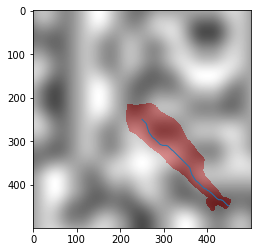

In [ ]:
m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

# 4. Tests

In order to make sure that our code is working properly, we have recorded the output for the 5 following seeds. 

As it can be demonstrated in the graphs, all of the path costs are the same as the optimal path cost or within a margin of 0.3 that was previously calulated for us. We can see the comparison bellow: 

```
 Seed 0 - path cost: 241.55253710831192   / optimal path cost: 241.55253710831192
 Seed 1 - path cost: 238.5060683830129   / optimal path cost: 238.5060683830129 
 Seed 2 - path cost: 243.8922386226827  / optimal path cost: 236.667690049357 
 Seed 3 - path cost:422.01798243905006 / optimal path cost: 422.01798243905006 
 Seed 4 - path cost:254.34464507852198/ optimal path cost: 254.34464507852198 
```
It is important to mention that not only did we recorded the path cost, but we have also obtained the number of nodes expanded and also the time efficiency to obtain the optimal path. It is clear that using the ***A**** algorithm we were able to improve ***The Skamania II GPS's off-trail pathfinding fearure***. This optimality was obtained by desgining an admissible heaurstics.  

## 4.1 Seeds

Time (s):  15.99951982498169
Path cost: 241.55253710831192
Nodes explored:  158676


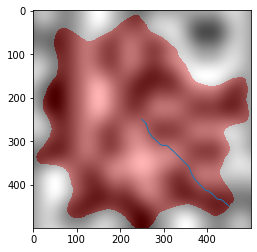

In [ ]:
w = 500
l = 500
start = None
goal = None

seed = 0

AI = Dijkstras()
# AI = AStarExp()
#AI = AStarMSH()
filename = None
m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  13.785767555236816
Path cost: 238.5060683830129
Nodes explored:  137407


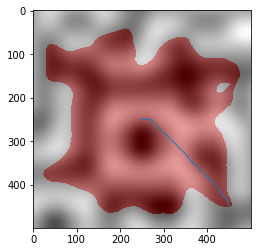

In [ ]:
seed = 1

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  13.306017875671387
Path cost: 236.667690049357
Nodes explored:  131500


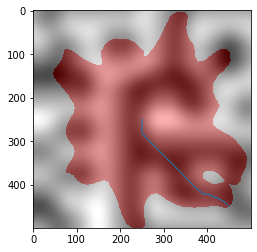

In [ ]:
seed = 2

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  26.315637350082397
Path cost: 422.01798243905006
Nodes explored:  214039


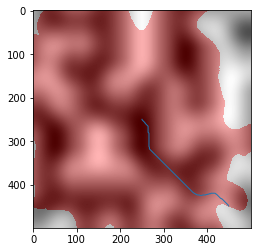

In [ ]:
seed = 3

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  12.160812854766846
Path cost: 254.34464507852198
Nodes explored:  120155


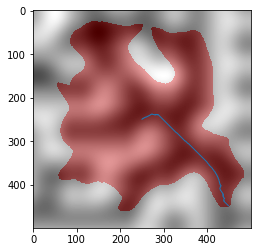

In [ ]:
seed = 4

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.2 MSH

In order to make sure that our code is working properly for the MSH problem, we have tested the implementation bellow: 

As it can be seen, the optimal path was found in under 20s which indicates that the time efficiency was improved and as a result, less nodes were explored. This implementation should help the hiker to get the optimal path quicker. 

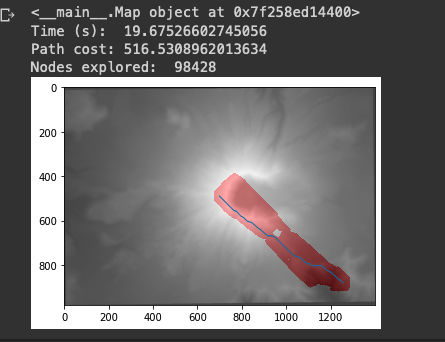

Time (s):  19.67526602745056
Path cost: 516.5308962013634
Nodes explored:  98428


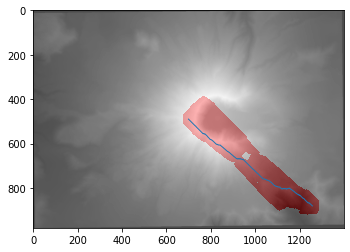

In [ ]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarMSH() after implemented
#AI = Dijkstras()
#AI = AStarExp()
AI = AStarMSH()
filename = "/content/gdrive/My Drive/Colab-Notebooks/msh.npy"

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
print(m)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

In [ ]:
import os